In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


import matplotlib.pyplot as plt
import numpy as np

## Set up

In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def show_image(img:torch.Tensor, label:int=None, title:str=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.imshow((np.transpose(npimg, (1, 2, 0))*255).astype('uint8'))
    if label is not None:
        plt.title(classes[label])
    elif title is not None:
        plt.title(title)
    plt.show()

In [3]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 10
    schedule_type = 'cosine'
    s = 0.008

## Dataset

In [4]:
import torch.utils
from torch.utils.data import DataLoader


class CIFAR10_Dataset():
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform if transform else transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.load_set()
        

    def load_set(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.set = torchvision.datasets.CIFAR10(root='./data', train = (self.split=='train'),
                                        download=True, transform=transform)
     
    def show_image(self, idx):
        img = self[idx]
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    
    def __getitem__(self, idx:int) -> torch.Tensor:
        """
        Returns a Tensor of shape (3 x 32 x 32)
        """
        return self.set[idx]
        
    def __len__(self) -> int:
        return len(self.set)
    
    def __str__(self) -> str:
        return f"CIFAR dataset of size {len(self)}"
    def __repr__(self) -> str:
        return str(self)

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


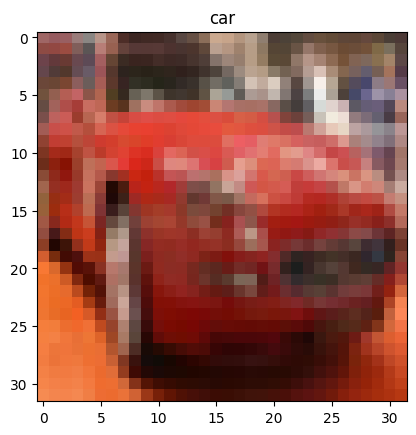

In [5]:
image, label = train[5]
show_image(image, label)

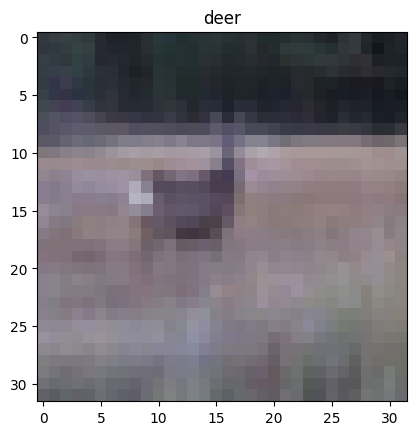

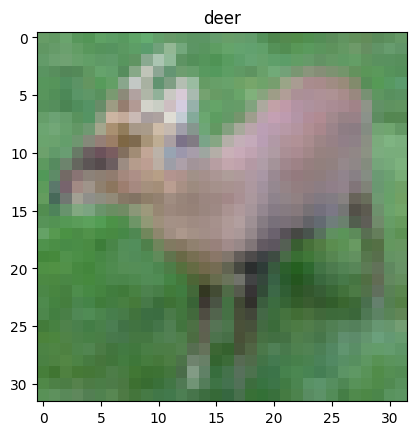

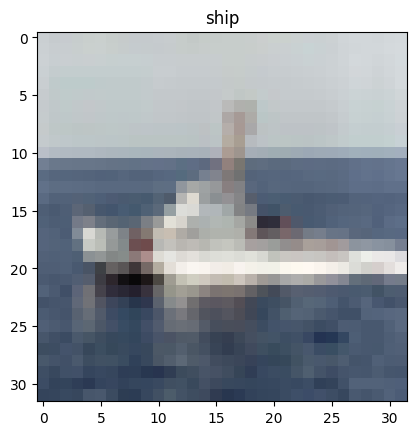

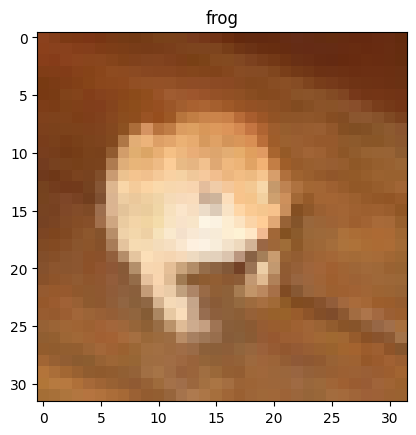

In [6]:
images, labels = next(iter(train_loader))
for image, label in zip(images, labels):
    show_image(image, label)

## Noise

In [7]:
def add_noise(img:torch.Tensor, B_t):
    noise = torch.randn_like(img)
    x_t =  torch.sqrt(1 - B_t) * img + torch.sqrt(B_t) * noise
    return x_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


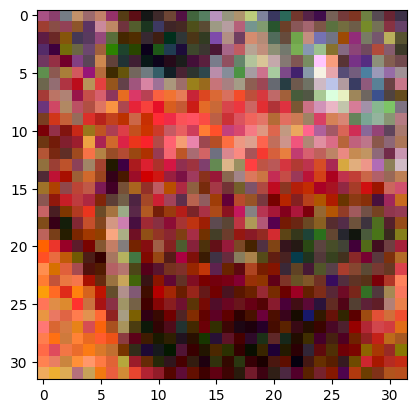

In [8]:
image, label = train[5]
# print(image)

B_t = torch.tensor(2e-2)
noise_image = add_noise(image, B_t)
noise_image = add_noise(noise_image, B_t)
show_image(noise_image)

### Schedule

In [9]:
class NoiseSchedule():
    def __init__(self, T:int, schedule_type:str, B_0:float, B_T:float):
        self.T = T
        self.schedule_type = schedule_type
        self.B_0 = B_0
        self.B_T = B_T
        self.t = 0
        if self.schedule_type == 'linear':
            self.schedule = self.linear_schedule()
        elif self.schedule_type == 'cosine':
            self.schedule = self.cosine_schedule()
        elif self.schedule_type == 'cosine2':
            self.schedule = self.cosine_schedule2()
        

    def linear_schedule(self) -> callable:
        return lambda t: torch.tensor(self.B_0 + (self.B_T - self.B_0) * t / self.T)
    def cosine_schedule(self):
        return lambda t: torch.tensor(self.B_0 + 0.5 * (self.B_T - self.B_0) * (1 - np.cos(np.pi * (t + 0.5) / self.T)))

    def cosine_schedule2(self):
        s=0.008
        return lambda t: torch.tensor(np.cos(((t/self.T) + s)/(1+s) * np.pi/2)**2)
    
    
    def __getitem__(self, t:int) -> float:
        if t >= self.T:
            raise IndexError(f"t must be less than {self.T}")
        return self.schedule(t)
    
    def __next__(self):
        self.t += 1
        return self.schedule(self.t)
    def __iter__(self):
        return self
    
    def plot_schedule(self):
        x = range(0, self.T)
        y = [self.schedule(t) for t in x]
        plt.plot(x, y)
        plt.show()
    

tensor(0.0002, dtype=torch.float64)
tensor(0.0012, dtype=torch.float64)


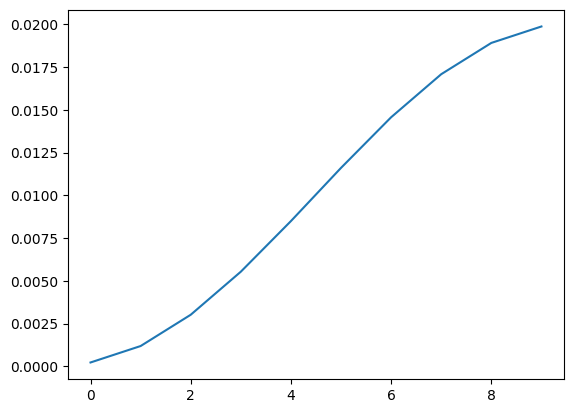

In [10]:
Schedule = NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
Schedule = NoiseSchedule(CFG.T, 'linear', CFG.B_0, CFG.B_T)
Schedule = NoiseSchedule(CFG.T, 'cosine', CFG.B_0, CFG.B_T)
print(Schedule[0])

var = next(Schedule)
print(var)

Schedule.plot_schedule()

In [11]:
class NoiseAdder():
    def __init__(self, noise_schedule:NoiseSchedule = None):            
        self.Schedule = noise_schedule if noise_schedule else NoiseSchedule(CFG.T, CFG.schedule_type, CFG.B_0, CFG.B_T)
    
    def add_noise(self, img:torch.Tensor, B_t):
        noise = torch.randn_like(img)
        x_t =  torch.sqrt(1 - B_t) * img + torch.sqrt(B_t) * noise
        return x_t
    
    def image_at_time_step(self, img:torch.Tensor, t):
        if t>=self.Schedule.T:
            raise(ValueError(f"The value should be lower than {self.Schedule.T}"))
        alpha_t_barre = torch.prod(torch.tensor([(1 - self.Schedule.schedule(s)) for s in range(t)]))
        noise = torch.randn_like(img)
        return torch.sqrt(alpha_t_barre) * img + torch.sqrt(1 - alpha_t_barre) * noise

    def image_at_time_step_cosine_v2(self, img:torch.Tensor, t):
        if t>=self.Schedule.T:
            raise(ValueError(f"The value should be lower than {self.Schedule.T}"))
        s=0.008
        # alpha_t_barre = torch.prod(torch.tensor([(1 - self.Schedule.schedule(s)) for s in range(t)]))
        f = lambda x: torch.tensor(np.cos(((x/self.Schedule.T) + s)/(1+s) * np.pi/2)**2)
        alpha_t_barre = f(t)/f(0)
        noise = torch.randn_like(img)
        return torch.sqrt(alpha_t_barre) * img + torch.sqrt(1 - alpha_t_barre) * noise

### Cosine Noise adder

In [12]:
class CosineNoiseAdder():
    def __init__(self, T:torch.Tensor, s=0.008):
        self.T = T
        self.s = s # The value of s is selected such that sqrt(B_0) is slightly smaller than the pixel bin size 1/127.5, which gives s = 0.008. 
        
    def image_at_time_step(self, img:torch.Tensor, t):
        if t>=self.T:
            raise(ValueError(f"The value should be lower than {self.T}"))
        f = lambda x: torch.tensor(np.cos(((x/self.T) + self.s)/(1+self.s) * np.pi/2)**2)
        alpha_t_barre = f(t)/f(0)
        noise = torch.randn_like(img)
        noisy_image = torch.sqrt(alpha_t_barre) * img + torch.sqrt(1 - alpha_t_barre) * noise
        return noisy_image, noise

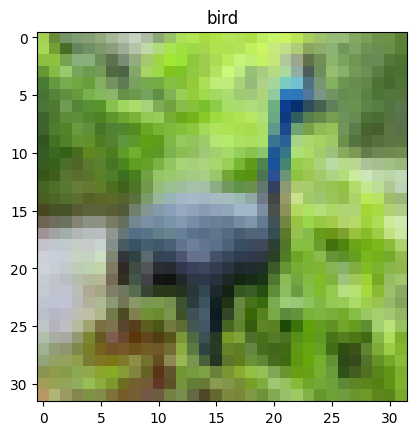

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


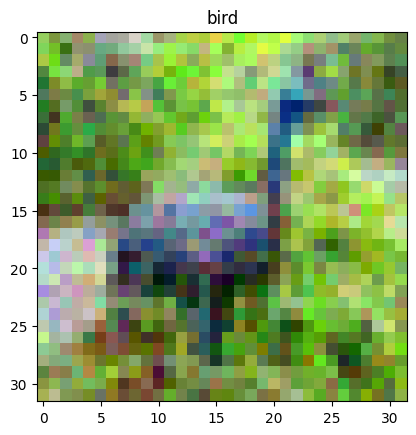

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


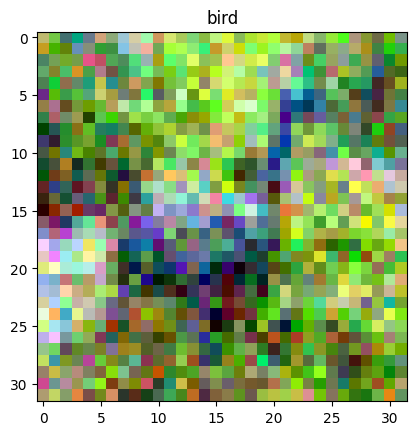

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


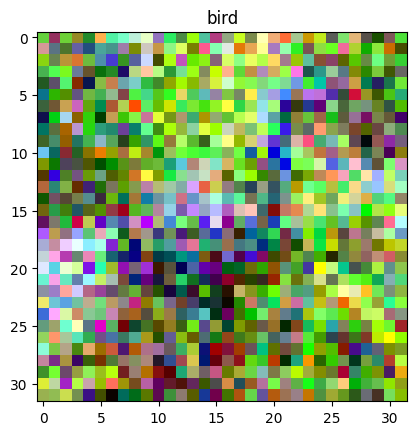

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


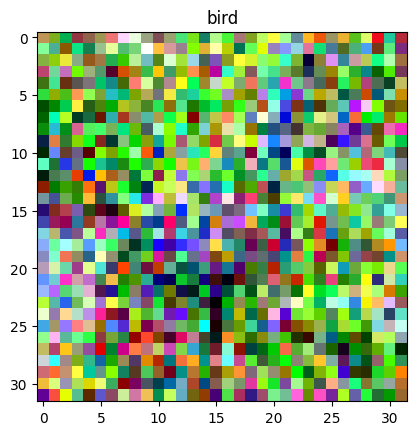

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


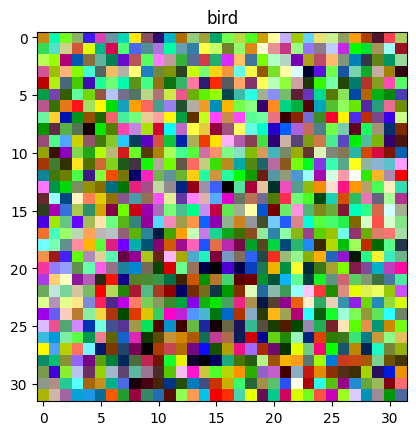

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


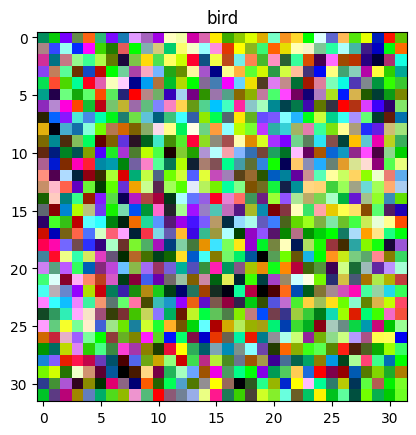

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


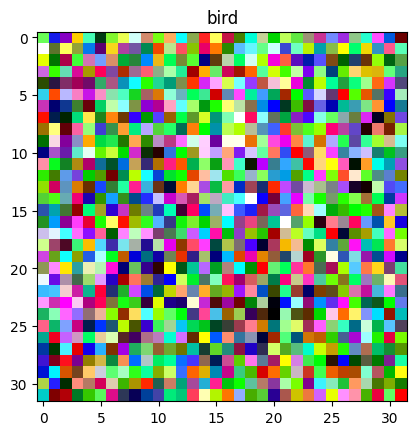

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


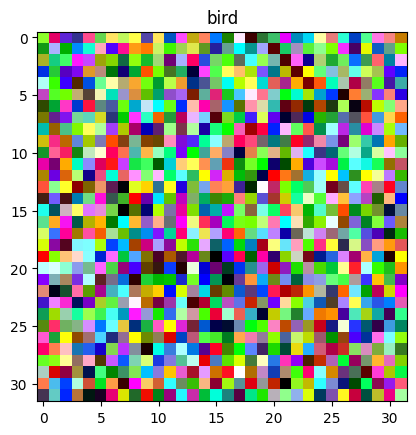

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


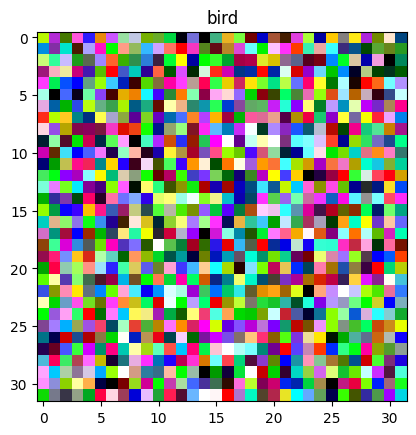

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


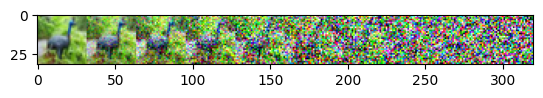

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


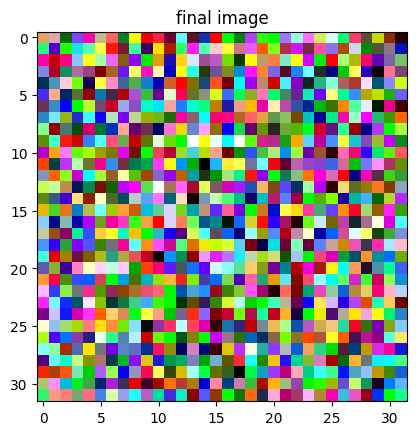

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


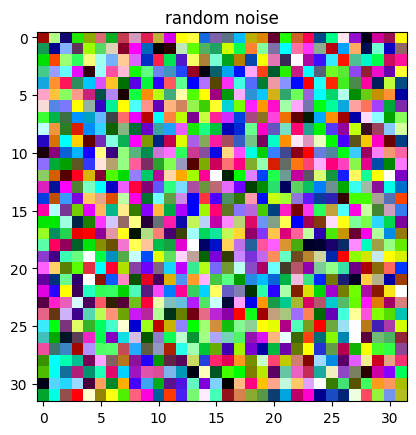

In [13]:
noise_adder = CosineNoiseAdder(CFG.T, CFG.s)

# Example input image
img, label = train[6]
full_img = torch.tensor([])

# Visualize the noise addition process
for t in range(0, CFG.T, 1):
    noisy_img, noise = noise_adder.image_at_time_step(img, t)
    full_img = torch.cat((full_img, noisy_img), 2)
    show_image(noisy_img, label)
show_image(full_img)

final_noisy_img, noise = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img, title="final image")

final_noise = torch.randn_like(img)
show_image(final_noise, title="random noise")

## Model

In [14]:
class UnetCFG:
    batch_size = 1

# train = CIFAR10_Dataset()
# train_loader = DataLoader(train, shuffle=True, batch_size=16)
# batch = next(iter(train_loader))
# print(batch[0].shape)
# # img, label = train[6]
# imgs = batch[0]

# fake data for testing
imgs = torch.randn(16, 3, 128, 128)

In [89]:
import torch.nn as nn

class DownBlock(nn.Module):
    def __init__(self, input_channels:int, output_channels:int, kernel_size:int=3):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size, padding=1)
        self.max_pooling = nn.MaxPool2d(kernel_size=1, stride=2)

    def forward(self, x):
        # print("down block : ")
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x_link = self.relu(self.conv2(x))
        
        # print(x.shape)
        x = self.max_pooling(x_link)
        # print(x.shape)
        return x, x_link

class BottleNeck(nn.Module):
    def __init__(self, input_channels:int, hidden_channels:int, kernel_size:int=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=1)
        self.up_conv = nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # print("BottleNeck : ")
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.relu(self.up_conv(x))
        # print(x.shape)
        return x

class UpBlock(nn.Module):
    def __init__(self, input_channels:int, kernel_size:int=3):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels * 2, input_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=1)
        self.up_conv = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)

    def forward(self, x:torch.Tensor, x_connection:torch.Tensor):
        # print("up block : ")
        # print("shapes : ", x.shape, x_connection.shape)
        x = torch.cat([x, x_connection], dim=1)
        # print('after concat : ', x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.relu(self.up_conv(x))
        # print(x.shape)
        return x

class FinalBlock(nn.Module):
    def __init__(self, input_channels, output_channels:int=3):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels * 2, input_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x:torch.Tensor, x_connection:torch.Tensor):
        # print("Final block : ")
        # print("shapes : ", x.shape, x_connection.shape)
        x = torch.cat([x, x_connection], dim=1)
        # print('after concat : ', x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.relu(self.final_conv(x))
        # print(x.shape)
        return x

class Unet(nn.Module):
    def __init__(self, first_hidden:int = 16, depth:int = 3):
        super().__init__()
        d = depth - 1
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        
        self.down_blocks.append(DownBlock(3, first_hidden))
        for i in range(d):
            self.down_blocks.append(DownBlock(first_hidden * 2**i, first_hidden * 2**(i+1)))
        
        self.bottleneck = BottleNeck(first_hidden*2**d, first_hidden*2**(d+1))
        
        for i in range(d, 0, -1):
            self.up_blocks.append(UpBlock(first_hidden * 2**i))
            
        self.final = FinalBlock(first_hidden, 3)
        

    def forward(self, x):
        links = []
        for i, block in enumerate(self.down_blocks):
            print(f'down block {i}, with shape {x.shape}')
            x, xi = block(x)
            links.append(xi)
        
        x = self.bottleneck(x)
        print(f'after bottleneck : shape = {x.shape}')
        
        for i, block in enumerate(self.up_blocks):
            print(f'up block {i}, with shape {x.shape}')
            x = block(x, links.pop())
        
        x = self.final(x, links[0])
        print(f'after final : shape = {x.shape}')
        
        return x



In [93]:
net = Unet()
print("\n", net(imgs).shape)

down block 0, with shape torch.Size([16, 3, 128, 128])
down block 1, with shape torch.Size([16, 16, 64, 64])
down block 2, with shape torch.Size([16, 32, 32, 32])
after bottleneck : shape = torch.Size([16, 64, 32, 32])
up block 0, with shape torch.Size([16, 64, 32, 32])
up block 1, with shape torch.Size([16, 32, 64, 64])
after final : shape = torch.Size([16, 3, 128, 128])

 torch.Size([16, 3, 128, 128])
